# Top 5 Quotes dummy model

In [1]:
import pandas as pd
import itertools
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import string
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = "../raw_data/quotes - reduced.csv"
quotes = pd.read_csv(file, decimal=",")
quotes.head(3)

,quote,author,category
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed-no-source, dreams, love, reality, s..."


In [3]:
tags_list = quotes.category.to_list()
number_of_tags = []
for i in tags_list:
    number_of_tags.append(len(str(i).split(',')))

In [4]:
quotes['quotes_length'] = quotes['quote'].copy()
for index, row in quotes.iterrows():
    quotes.loc[index, "quotes_length"] = len(str(row['quotes_length']).split(' '))

## Cleaning data: tags are all lowercase, '-' were replaced with ',', duplicates were removed

In [5]:
for index, row in quotes.iterrows():
    quotes.loc[index, "category"] = str(row['category']).lower().replace('-',', ')

In [6]:
quotes['list_tags'] = quotes['category'].copy()
for index,row in quotes.iterrows():
    quotes.loc[index, 'count_tags'] = len(str(row['list_tags']).split(','))
quotes.count_tags.describe()

count    156656.000000
mean          9.747638
std          15.356019
min           1.000000
25%           3.000000
50%           5.000000
75%          11.000000
max         568.000000
Name: count_tags, dtype: float64

In [7]:
for index,row in quotes.iterrows():
    quotes.at[index, 'list_tags'] = str(row['list_tags']).split(',')

In [8]:
for index,row in quotes.iterrows():
    quotes.at[index, 'list_tags'] = str(set(row['list_tags']))

In [9]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
quotes['list_tags'] = quotes['list_tags'].apply(remove_punctuations)

In [10]:
vectorizer = TfidfVectorizer()
tags_vectorized = vectorizer.fit_transform(quotes['list_tags'])
dummy_tags = LatentDirichletAllocation(n_components=5)
lda_vectors = dummy_tags.fit_transform(tags_vectorized)

In [11]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(dummy_tags, vectorizer.fit(quotes['list_tags']))

Topic 0:
[('humor', 2164.5693270988104), ('religion', 1470.5032612971058), ('god', 1280.1688752970276), ('humour', 1194.4367560747419), ('music', 1179.8508193980667), ('feminism', 1049.3683685626347), ('christianity', 1008.1443057504287), ('funny', 952.2040905722603), ('politics', 889.574627820969), ('war', 857.05461190538)]
Topic 1:
[('love', 1392.2060086730412), ('debasish', 1314.5492760276848), ('friendship', 1129.512472145731), ('quotes', 1012.7257027782887), ('mridha', 949.7364771807445), ('life', 909.3767115477734), ('inspirational', 840.2670277504025), ('romance', 809.5708015240504), ('sex', 790.4169461721655), ('courage', 682.9755010282946)]
Topic 2:
[('inspirational', 3482.2237322494248), ('life', 2338.850606863753), ('quotes', 2035.9375566972672), ('motivational', 1643.1329809429321), ('inspiration', 1482.1081975111365), ('self', 1456.1392449842656), ('lessons', 1247.9717913151455), ('motivation', 1215.9191150993818), ('spiritual', 1057.3308511116948), ('art', 1033.4506911822

In [12]:
lda_vectors[1]

array([0.05932556, 0.42108086, 0.0597981 , 0.05887248, 0.400923  ])

In [13]:
quotes.iloc[-1] = ['me, Paris, selfie, singing, book','image','image','5','me, Paris, selfie, singing, book','1']

In [14]:
picture_vectorized = vectorizer.transform(quotes.iloc[-1])
lda_vectors_self = dummy_tags.transform(picture_vectorized)
for index,row in quotes.iterrows():
    quotes['topic'] = quotes.quote.copy()

In [15]:
for index,row in quotes.iterrows():
    quotes.at[index, 'topic'] = int(np.where(lda_vectors[index] == max(lda_vectors[index]))[0])

In [16]:
quotes.tail()

,quote,author,category,quotes_length,list_tags,count_tags,topic
156651,The harassed look is that of a desperately tir...,"Christopher Isherwood, A Single Man","dying, living",96,dying living,2.0,4
156652,…In this way that he sought to control the ver...,"Jesse Ball, The Curfew","life, living, mindfulness",39,mindfulness life living,3.0,2
156653,"No matter how we choose to live, we both die a...","Adam Silvera, They Both Die at the End","death, living",13,death living,2.0,4
156654,The goal that you hope you will one day arrive...,"Marcus Aurelius, The Essential Marcus Aurelius",living,239,living,1.0,2
156655,"me, Paris, selfie, singing, book",image,image,5,"me, Paris, selfie, singing, book",1,3


(array([25343.,     0., 34534.,     0.,     0., 34498.,     0., 32329.,
            0., 29952.]),
 array([0.0, 0.4, 0.8, 1.2000000000000002, 1.6, 2.0, 2.4000000000000004,
        2.8000000000000003, 3.2, 3.6, 4.0], dtype=object),
 <BarContainer object of 10 artists>)

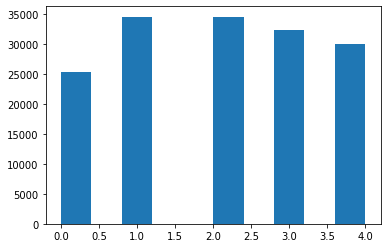

In [17]:
plt.hist(quotes.topic)

__Adding the image caption as the last line to our dataset to be able to see the closest neighbourhs__

In [18]:
image_topic = int(quotes.iloc[-1, [-1]])
image_topic

3

In [19]:
quotes = quotes.dropna()
only_topic = quotes[quotes.topic == image_topic]
only_topic.head()

,quote,author,category,quotes_length,list_tags,count_tags,topic
27,We’re all a little weird. And life is a little...,"Robert Fulghum, True Love","love, weirdness",37,love weirdness,2.0,3
36,To die will be an awfully big adventure.,"J.M. Barrie, Peter Pan","adventure, love",8,adventure love,2.0,3
37,A lady's imagination is very rapid; it jumps f...,"Jane Austen, Pride and Prejudice","humor, love, romantic, women",19,romantic love humor women,4.0,3
53,In vain have I struggled. It will not do. My f...,"Jane Austen, Pride And Prejudice","love, mr, darcy",29,mr darcy love,3.0,3
58,The only thing worse than a boy who hates you:...,"Markus Zusak, The Book Thief","boys, hate, love",15,hate love boys,3.0,3


In [20]:
tfidf_weight = vectorizer.fit_transform(only_topic['list_tags'].values.astype('U'))
nn_euc = NearestNeighbors(metric = 'euclidean')
nn_euc.fit(tfidf_weight)
image_index = -1
euc, indices = nn_euc.kneighbors(tfidf_weight[image_index], n_neighbors = 100)
neighbors_euc = pd.DataFrame({'euc': euc.flatten(), 'id': indices.flatten()})
result_top5 = (only_topic.merge(neighbors_euc, right_on = 'id', left_index = True).
                sort_values('euc')[['quote', 'author']]).head()

result_top5

,quote,author
7,Tous mes anciens amours vont me revenir.'- All...,"Carolyn Turgeon, Godmother: The Secret Cindere..."
8,"Go on, get out! Last words are for fools who h...",Karl Marx
16,A farm includes the passion of the farmer's he...,"Joel Salatin, Everything I Want to Do Is Illeg..."
23,...Nobody knows like a woman how to say things...,"Victor Hugo, Les Misérables"
25,"You’ll see,” Mother assured her. “The fish wil...","Melanie Crowder, A Nearer Moon"


In [21]:
most_suiting = quotes[quotes.topic != image_topic]
own_tags = input("Please give me 5 words that are descriptive of your picture:")
most_suiting.iloc[-1] = [own_tags,'image','image','5',own_tags,'1',image_topic]
most_suiting.tail()

Please give me 5 words that are descriptive of your picture:yellow, face, selfie, me, Paris


/tmp/ipykernel_3514/101407589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_suiting.iloc[-1] = [own_tags,'image','image','5',own_tags,'1',image_topic]


,quote,author,category,quotes_length,list_tags,count_tags,topic
156650,Sasha's green eyes were right up against yours...,"Jennifer Egan, A Visit from the Goon Squad","coping, living, survival",77,coping survival living,3.0,1
156651,The harassed look is that of a desperately tir...,"Christopher Isherwood, A Single Man","dying, living",96,dying living,2.0,4
156652,…In this way that he sought to control the ver...,"Jesse Ball, The Curfew","life, living, mindfulness",39,mindfulness life living,3.0,2
156653,"No matter how we choose to live, we both die a...","Adam Silvera, They Both Die at the End","death, living",13,death living,2.0,4
156654,"yellow, face, selfie, me, Paris",image,image,5,"yellow, face, selfie, me, Paris",1,3


In [22]:
tfidf_weight = vectorizer.fit_transform(most_suiting['list_tags'].values.astype('U'))
nn_euc = NearestNeighbors(metric = 'euclidean')
nn_euc.fit(tfidf_weight)
image_index = -1
euc, indices = nn_euc.kneighbors(tfidf_weight[image_index], n_neighbors = 100)
neighbors_euc = pd.DataFrame({'euc': euc.flatten(), 'id': indices.flatten()})
result_most_s = (only_topic.merge(neighbors_euc, right_on = 'id', left_index = True).
                sort_values('euc')[['quote', 'author']]).head(1)

result_most_s

,quote,author
5,Establishing lasting peace is the work of educ...,all politics can do is keep us out of war.
